In [1]:
import pyedflib
import numpy as np

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.io import loadmat
%matplotlib inline

In [2]:
file_name = "./Subject00_2.edf"
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

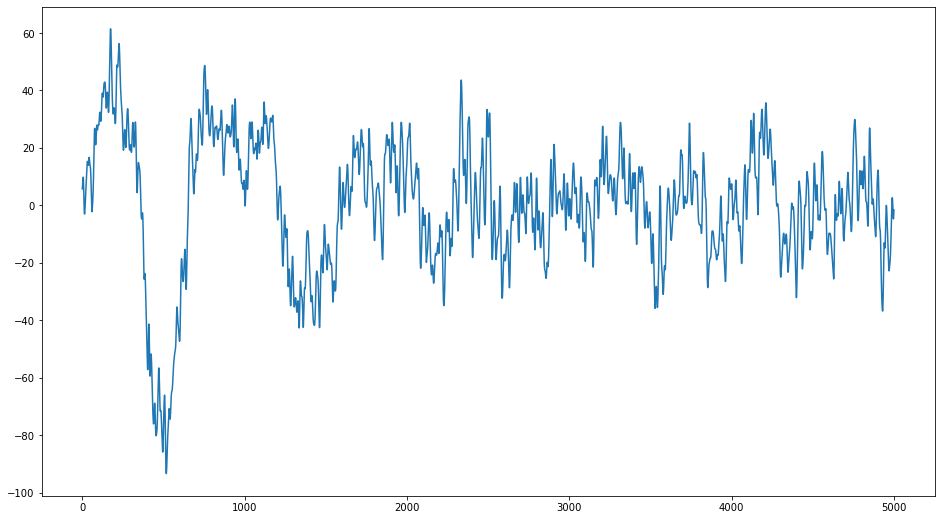

In [14]:
plt.figure(figsize=(16, 9))
plt.plot(test)

In [3]:
data = sigbufs[0]

train = data[:25000]
test =  data[25000:30000]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [4]:
lstm_train = train
lstm_test =  test

mean = lstm_train.mean()
std = lstm_train.std()
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean)/std
test_norm = (lstm_test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [5]:
rmse_lstm_cont = np.load("con_lstm_rmse.npy")
lstm_predicts_cont = np.load("con_lstm_predicts.npy")

In [6]:
bin_lstm_predicts = np.load("bin_lstm_predicts.npy")
wave_predicts_cont = np.load("wavenet_predict_all_steps_cont_siez.npy")
wave_predicts_bin = np.load("wavenet_predict_all_steps_bin_new.npy")

In [7]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [8]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [9]:
test_right_part = (len(test)- 20)%64

In [10]:
lstm_rmses_bin = []
lstm_rmses_bin.append(CalcRMSE(int_to_amp(bin_lstm_predicts[0][1:], data[:-1000]), test[20:-test_right_part]))
for i in tqdm(range(1, 19)):
    lstm_rmses_bin.append(CalcRMSE(int_to_amp(bin_lstm_predicts[i][1:], data[:-1000], n=256)[:-i], test[20+i: -test_right_part]))

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 8997.43it/s]


In [21]:
wavenet_rmses_cont = []
for i in tqdm(range(19)):
    wavenet_rmses_cont.append(CalcRMSE(wave_predicts_cont[:, 1:][i][:-1-i], data[-5999 + i:-1000]))

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19005.91it/s]


In [27]:
wavenet_rmses = []
for i in tqdm(range(19)):
    wavenet_rmses.append(CalcRMSE(int_to_amp(wave_predicts_bin[:, 1:][i], data[:-1000], n=256)[:-1-i], data[-5999 + i:-1000]))

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 9499.56it/s]


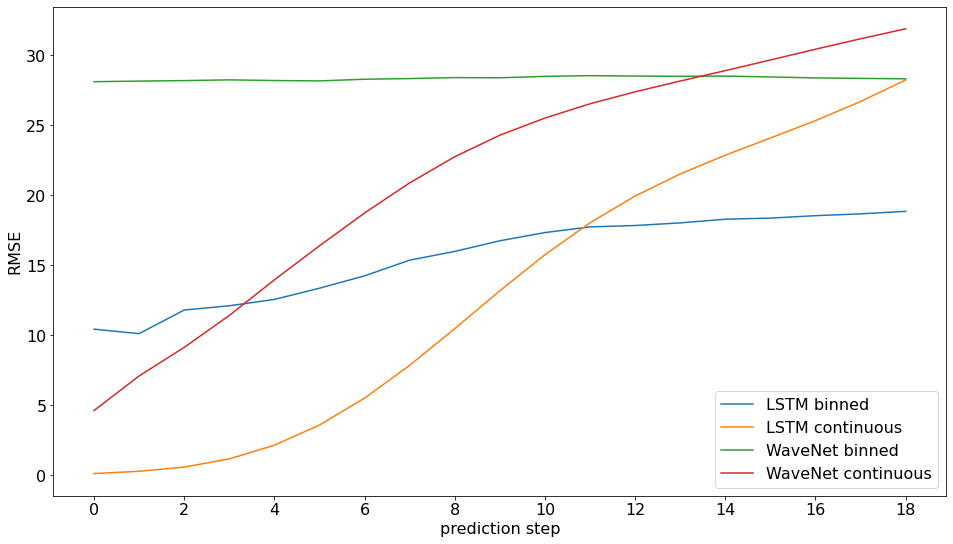

<Figure size 1152x648 with 0 Axes>

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(lstm_rmses_bin, label="LSTM binned")
ax.plot(rmse_lstm_cont, label="LSTM continuous")
ax.plot(wavenet_rmses, label="WaveNet binned")
ax.plot(wavenet_rmses_cont, label="WaveNet continuous")

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

plt.figure(figsize=(16, 9))


ax.legend(fontsize = 16)

In [20]:
def Plt(k):
    #k = 5
    fig = plt.figure(figsize = (16, 16))
#     ax_1 = fig.add_subplot(4, 1, 1)
#     ax_1.plot(data[-6000 + k:-6000 + k + 1000], label='true')
#     ax_1.plot(int_to_amp(wave_predicts_bin[:, 1:][k-1], data[:-1000], n=256)[:1000],  linestyle = '--', label='predicted')
#     ax_1.legend()
#     ax_1.set_title('WaveNet Bin')
    
#     fig = plt.figure(figsize = (16, 16))
#     ax_2 = fig.add_subplot(4, 1, 2)
#     ax_2.plot(data[-6000 + k:-6000 + k + 1000], label='true')
#     ax_2.plot(wave_predicts_cont[:, 1:][k-1][:1000],  linestyle = '--', label='predicted')
#     ax_2.legend()
#     ax_2.set_title('WaveNet Cont')
    fig. tight_layout (h_pad= 2 )
    
    ax_3 = fig.add_subplot(4, 1, 3)
    fig. tight_layout (h_pad= 2 )
    ax_3.plot(list(range(0, 800, 2)), lstm_test[20+k-1: 20+k-1 + 1000][600:1000], label='true')
    ax_3.plot(list(range(0, 800, 2)), lstm_predicts_cont[k-1][600:1000],  linestyle = '--', label='predicted')
    ax_3.legend()
    ax_3.set_title('LSTM', fontsize=16)
    
    ax_3.tick_params(axis='both', which='major', labelsize=16)
    #ax.set_title("RMSE",  fontsize = 16)
    ax_3.set_ylabel("V",  fontsize = 16)
    ax_3.set_xlabel("t, ms",  fontsize = 16)
    
    ax_4 = fig.add_subplot(4, 1, 4)
    fig. tight_layout (h_pad= 2 )
    ax_4.plot(list(range(0, 800, 2)), lstm_test[20+k-1: 20+k-1 + 1000][600:1000], label='true')
    ax_4.plot(list(range(0, 800, 2)), int_to_amp(bin_lstm_predicts[k-1][1:], data[:-1000], n=256)[600:1000],  linestyle = '--', label='predicted')
    ax_4.legend()
    ax_4.set_title('LSTM Bin', fontsize=16)
    
    ax_4.tick_params(axis='both', which='major', labelsize=16)
    #ax.set_title("RMSE",  fontsize = 16)
    ax_4.set_ylabel("V",  fontsize = 16)
    ax_4.set_xlabel("t, ms",  fontsize = 16)
    
    plt.show()
    

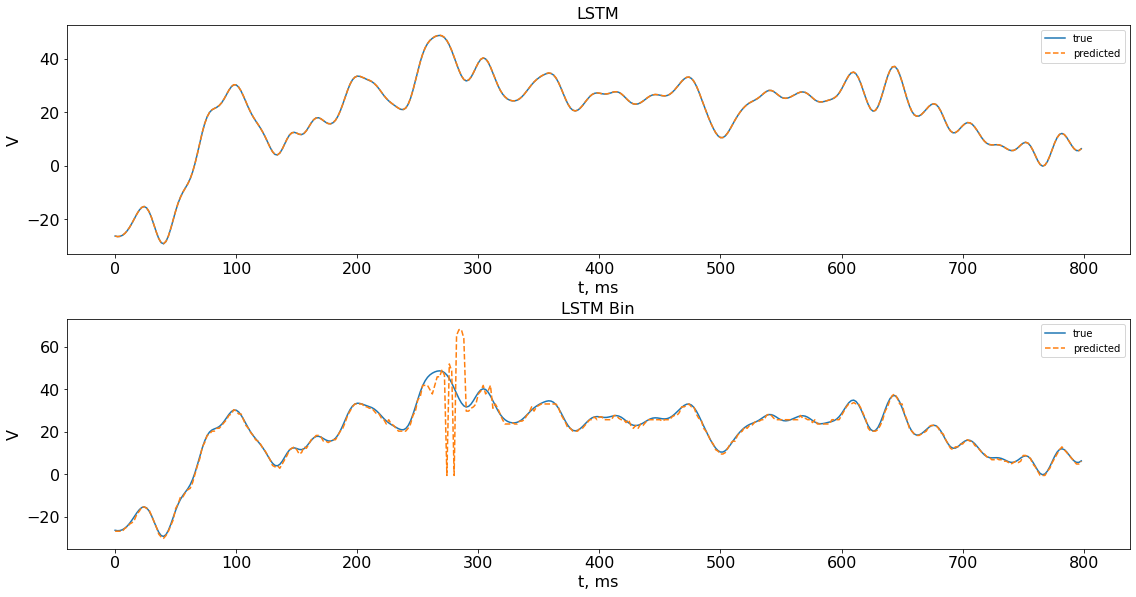

In [21]:
Plt(1)

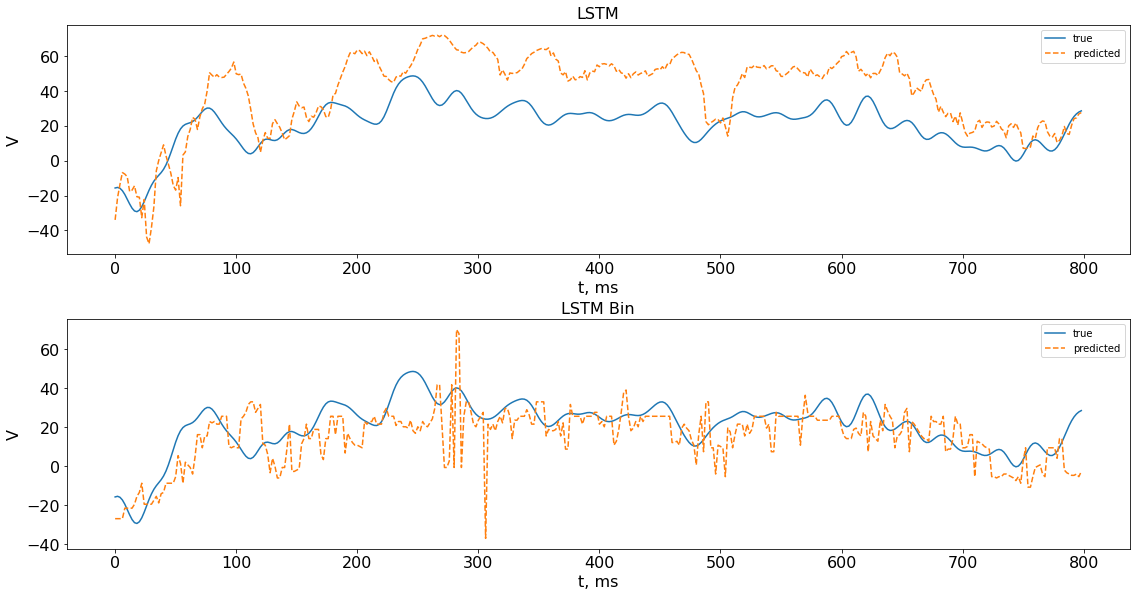

In [22]:
Plt(12)

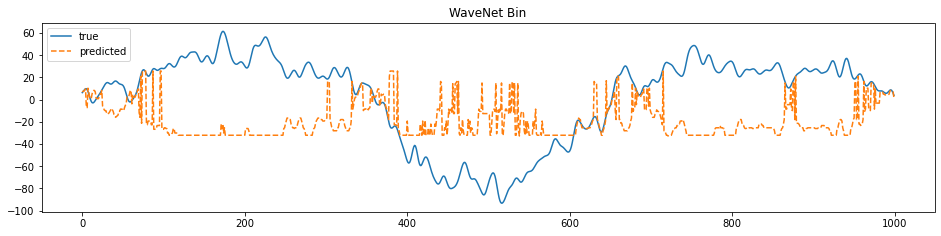

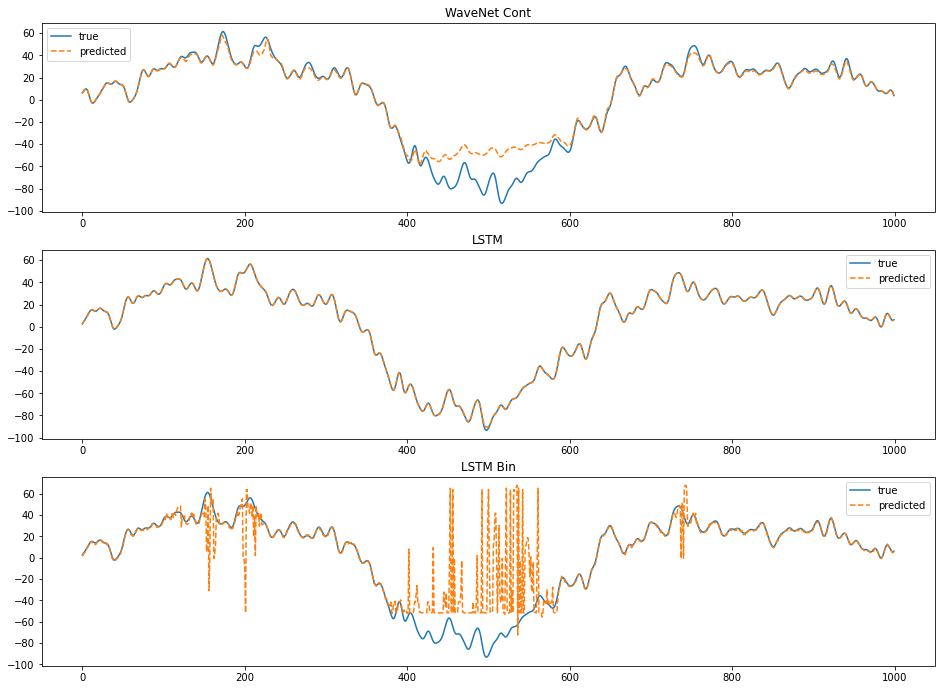

In [14]:
Plt(1)

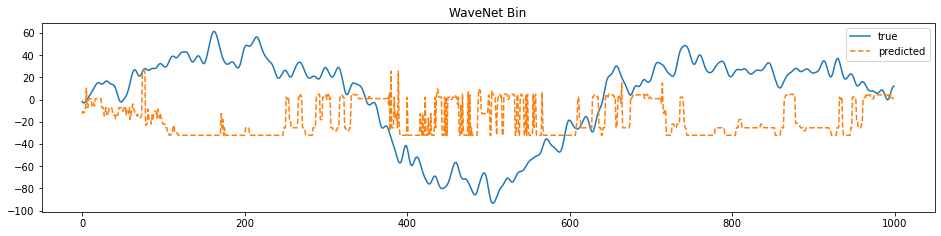

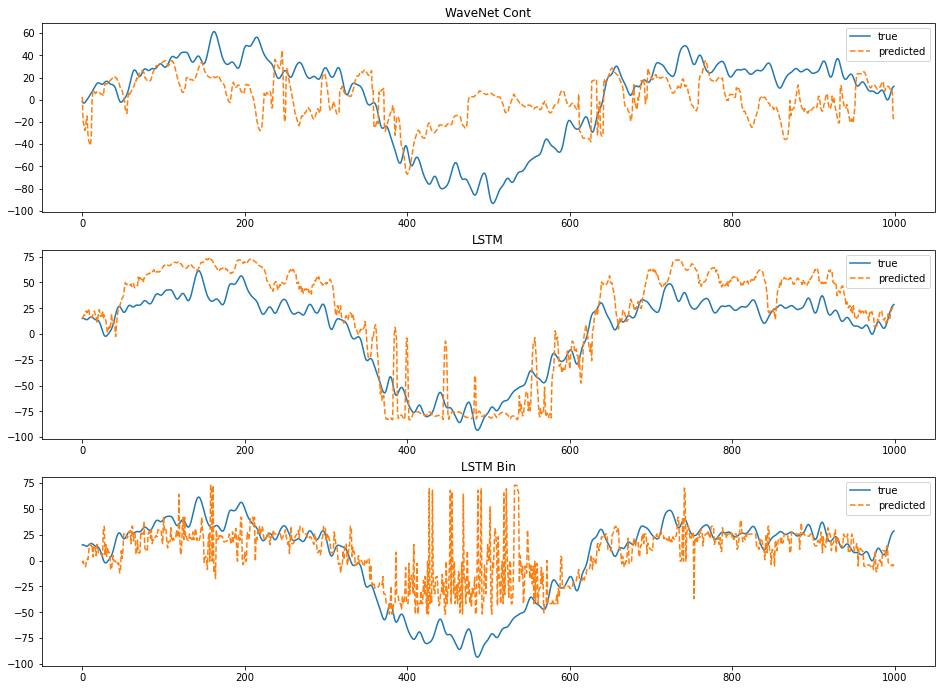

In [31]:
Plt(12)

In [25]:
mean + 4*std

59.28157707120911

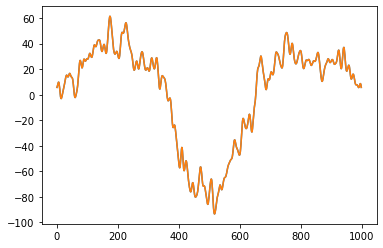

In [18]:
plt.plot(data[25000:-1000][:1000])
plt.plot(lstm_test[:1000])